**This notebook goes goes over training the U-Net segmentation models through Colab.**

In [ ]:
# First, begin with the imports. We will primarily be using numpy and tensorflow/ keras
from PIL import Image, ImageOps
import numpy as np
from numpy import asarray
from matplotlib import pyplot as plt
from keras.utils import normalize
import os

In [ ]:
# Our Google Drive is linked to the project's description. Simply pin that to your home for 
# connecting to the datasets that are provided
from google.colab import drive
drive.mount('/content/drive') # run if not mounted already

Mounted at /content/drive


In [ ]:
# Check to ensure if GPU is available
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
drive_dir = '/content/drive/MyDrive/Project TetraNet/files/dataset/'
image_names_dir = drive_dir + 'reference/'
mask_names_dir = drive_dir + 'masks/'

In [ ]:
image_names_list = sorted(os.listdir(image_names_dir))
mask_names_list = sorted(os.listdir(mask_names_dir))
print(image_names_list)
print(mask_names_list)

['1.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '2.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '3.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '4.png', '40.png', '5.png', '6.png', '7.png', '8.png', '9.png']
['1.png_annotation.ome.tiff', '10.png_annotation.ome.tiff', '11.png_annotation.ome.tiff', '12.png_annotation.ome.tiff', '13.png_annotation.ome.tiff', '14.png_annotation.ome.tiff', '15.png_annotation.ome.tiff', '16.png_annotation.ome.tiff', '17.png_annotation.ome.tiff', '18.png_annotation.ome.tiff', '19.png_annotation.ome.tiff', '2.png_annotation.ome.tiff', '20.png_annotation.ome.tiff', '21.png_annotation.ome.tiff', '22.png_annotation.ome.tiff', '23.png_annotation.ome.tiff', '24.png_annotation.ome.tiff', '25.png_annotation.ome.tiff', '26.png_annotation.ome.tiff', '27.png_annotation.ome.tiff', '28.png_a

In [ ]:
image_dataset = []
mask_dataset = []
img_shape = (128,128)
for x,y in zip(image_names_list, mask_names_list):
  img = Image.open(image_names_dir + x)
  img = ImageOps.grayscale(img)
  img = img.resize(img_shape)
  img = asarray(img)
  image_dataset.append(img)
  mask = Image.open(mask_names_dir + y)
  mask = ImageOps.grayscale(mask)
  mask = mask.resize(img_shape)
  mask = asarray(mask)
  mask_dataset.append(mask)


In [ ]:
image_dataset = np.array(image_dataset)
image_dataset = image_dataset.astype('uint8')
mask_dataset = np.array(mask_dataset)
mask_dataset = mask_dataset.astype('uint8')

In [ ]:
image_dataset_to_datagen = image_dataset.copy()
image_dataset_to_datagen = np.expand_dims(image_dataset_to_datagen, -1)

mask_dataset_to_datagen = mask_dataset.copy()
mask_dataset_to_datagen = np.expand_dims(mask_dataset_to_datagen, -1)

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
data_gen_args = dict(
    featurewise_center = True,
)

image_data_generator = ImageDataGenerator(
    featurewise_center= True,
    rotation_range= 90,
    zoom_range = [0.2, 1.0],
    dtype= 'float32'
)

image_datagen = image_data_generator
mask_datagen = image_data_generator #ImageDataGenerator(**data_gen_args)

print(image_dataset.shape, mask_dataset.shape)

# the same seed will allow for the same transformations
seed = 1
# fitting will "calculate any statistics required to actually perform the transformations"
image_datagen.fit(image_dataset_to_datagen, augment= False, seed=seed)
mask_datagen.fit(mask_dataset_to_datagen, augment= False, seed=seed)

image_generator = image_datagen.flow(image_dataset_to_datagen, batch_size= 40, seed=seed, shuffle= False)
mask_generator = mask_datagen.flow(mask_dataset_to_datagen, batch_size=40, seed=seed, shuffle= False)

train_generator = zip(image_generator, mask_generator)

(40, 128, 128) (40, 128, 128)


**Visualize the training dataset**

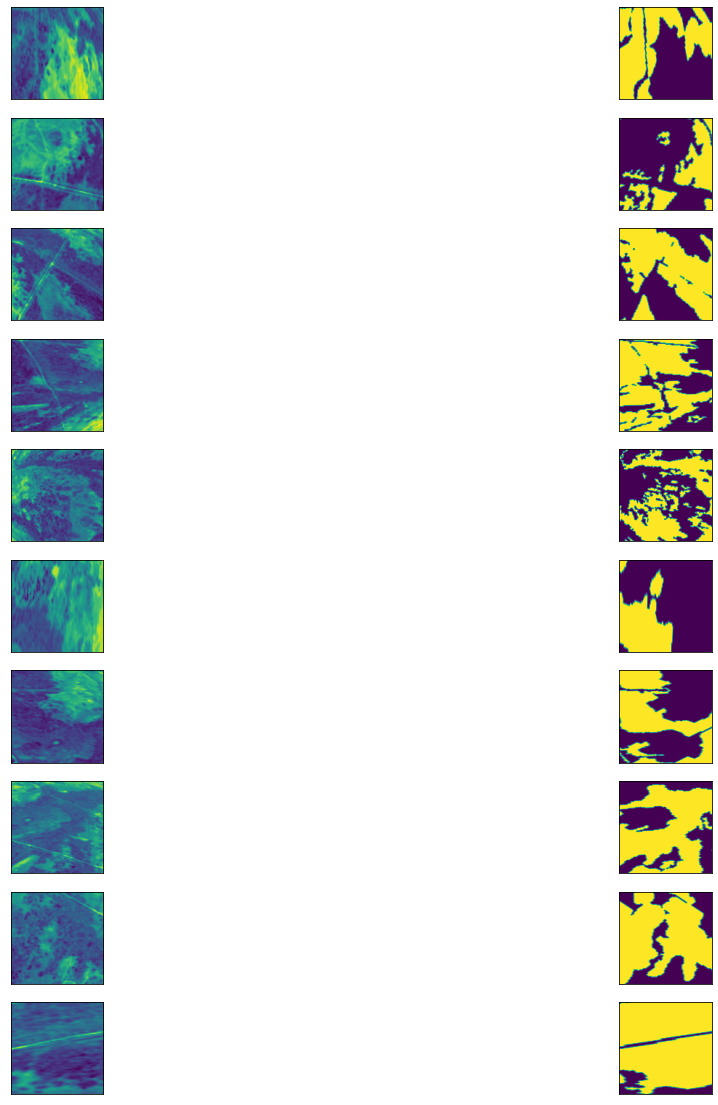

In [ ]:
fig, axs = plt.subplots(nrows= 10, ncols = 2, constrained_layout= False, figsize= (100,100), sharex= True, sharey= True)
r, c = 0,0

train_X = image_generator.next()
train_X = train_X.astype('uint8')
train_y = mask_generator.next()
train_X = np.squeeze(train_X, -1)
train_y = np.squeeze(train_y, -1)




for r in range (10):
  axs[r,0].imshow(train_X[r])
  axs[r, 0].get_xaxis().set_visible(False)
  axs[r, 0].get_yaxis().set_visible(False)

  axs[r, 1].imshow(train_y[r])
  axs[r, 1].get_xaxis().set_visible(False)
  axs[r, 1].get_yaxis().set_visible(False)

(440, 128, 128, 1) (440, 128, 128, 1)


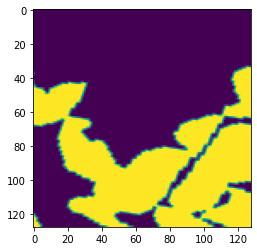

In [ ]:
# Concatenate all the randomly generated images into an appended dataset
# The seed values from the image and mask generators should return correlated images & masks

image_dataset_concat = image_generator.next()
mask_dataset_concat = mask_generator.next()

plt.imshow(np.squeeze(mask_dataset_concat[0], -1))

for i in range(10):
  image_dataset_concat = np.concatenate((image_dataset_concat, image_generator.next()))
  mask_dataset_concat = np.concatenate((mask_dataset_concat, mask_generator.next()))

print(image_dataset_concat.shape, mask_dataset_concat.shape)

[-0.365448   -0.3654479  -0.36544737 ...  0.6345517   0.63455176
  0.634552  ]
[0 1]


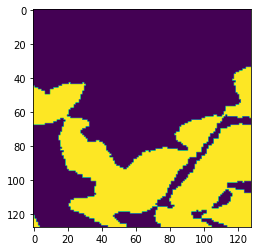

In [ ]:
# 
print(np.unique(mask_dataset_concat))
p = mask_dataset_concat.copy()
p = np.around(p, 0)
p = p.astype('uint8')
print(np.unique(p))

plt.imshow(np.squeeze(p[0], -1))

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [ ]:
# converts into already normalized images (can accept float32 or float64) / 255.0 -- normalized range [0,1]
def unet_model(IMGH, IMGW, CHANNELS, CLASSES):

  # begin with 1st layer input = 128x128x3 aka. 128x128 RGB image (3 channels)
  inputs = Input((IMGH, IMGW, CHANNELS))
  s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
  s = inputs

  c1 = Conv2D(filters= 16, kernel_size=3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(s)
  c1 = Dropout(rate= 0.1)(c1)
  c1 = Conv2D(filters= 16, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c1)
  
  # move into 2nd layer : convolution 1
  m1 = MaxPooling2D(pool_size= 2)(c1)
  # m1 becomes input to c2
  c2 = Conv2D(filters= 32, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(m1)
  c2 = Dropout(rate= 0.1)(c2)
  c2 = Conv2D(filters= 32, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c2)

  # move into 3rd layer : convolution 2
  m2 = MaxPooling2D(pool_size= 2)(c2)
  c3 = Conv2D(filters= 64, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(m2)
  c3 = Dropout(rate= 0.2)(c3)
  c3 = Conv2D(filters= 64, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c3)

  # move into 4th layer : convolution 3
  m3 = MaxPooling2D(pool_size= 2)(c3)
  c4 = Conv2D(filters= 128, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(m3)
  c4 = Dropout(rate= 0.2)(c4) 
  c4 = Conv2D(filters= 128, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c4)

  # move into 5th layer : convolution 4 (last convolution step)
  m4 = MaxPooling2D(pool_size= 2)(c4)
  # deepest layer, shape = 8x8x256
  c5 = Conv2D(filters= 256, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(m4)
  c5 = Dropout(rate= 0.3)(c5)
  c5 = Conv2D(filters= 256, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c5)

  # move back into 4th layer : upconvolution 1
  u1 = Conv2DTranspose(filters= 128, kernel_size= 2, strides= 2, padding= 'same')(c5)
  u1 = concatenate([u1, c4])
  c6 = Conv2D(filters= 128, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(u1)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(filters= 128, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c6)

  # move back into 3rd layer : upconvolution 2
  u2 = Conv2DTranspose(filters= 64, kernel_size= 2, strides= 2, padding= 'same')(c6)
  u2 = concatenate([u2, c3])
  c7 = Conv2D(filters= 64, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(u2)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(filters= 64, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c7)

  # move back into 2nd layer : upconvolution 3
  u3 = Conv2DTranspose(filters= 32, kernel_size= 2, strides= 2, padding= 'same')(c7)
  u3 = concatenate([u3, c2])
  c8 = Conv2D(filters= 32, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(u3)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(filters= 32, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c8)

  # move back into 1st layer : upconvolution 4
  u4 = Conv2DTranspose(filters= 16, kernel_size= 2, strides= 2, padding= 'same')(c8)
  u4 = concatenate([u4, c1], axis= 3)
  c9 = Conv2D(filters= 16, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(u4)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(filters= 16, kernel_size= 3, activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(c9)

  # return a classification model with sigmoid activation
  outputs = Conv2D(CLASSES, (1,1), activation= 'softmax')(c9)

  # define the beginning and starting points of the model aka. what you feed in and what you expect it to return
  model = Model(inputs = [inputs], outputs= [outputs])
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  model.summary()
    
  return model

In [ ]:
model= unet_model(img_shape[0], img_shape[1], 1, 2)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 128, 128, 16) 0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 2320        dropout_27[0][0]                 
____________________________________________________________________________________________

In [ ]:
from keras.utils import to_categorical
mask_dataset_concat = to_categorical(p)
print(p.shape, np.unique(p))

(440, 128, 128, 1) [0 1]


In [ ]:
model_history = model.fit(image_dataset_concat, mask_dataset_concat, validation_split= 0.1, epochs= 100, steps_per_epoch= 4, batch_size= 16, verbose= 1, shuffle= False)

Epoch 1/100
4/4 [==============================] - 0s 92ms/step - loss: 0.6764 - categorical_accuracy: 0.5931 - val_loss: 0.6709 - val_categorical_accuracy: 0.6053
Epoch 2/100
4/4 [==============================] - 0s 60ms/step - loss: 0.6606 - categorical_accuracy: 0.6282 - val_loss: 0.6709 - val_categorical_accuracy: 0.6053
Epoch 3/100
4/4 [==============================] - 0s 59ms/step - loss: 0.6711 - categorical_accuracy: 0.6049 - val_loss: 0.6709 - val_categorical_accuracy: 0.6053
Epoch 4/100
4/4 [==============================] - 0s 62ms/step - loss: 0.6774 - categorical_accuracy: 0.5909 - val_loss: 0.6709 - val_categorical_accuracy: 0.6053
Epoch 5/100
4/4 [==============================] - 0s 58ms/step - loss: 0.6544 - categorical_accuracy: 0.6418 - val_loss: 0.6709 - val_categorical_accuracy: 0.6053
Epoch 6/100
4/4 [==============================] - 0s 59ms/step - loss: 0.6839 - categorical_accuracy: 0.5765 - val_loss: 0.6709 - val_categorical_accuracy: 0.6053
Epoch 7/100
4/4 

ValueError: ignored

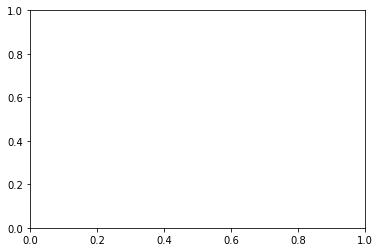

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(100)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
_, acc = model.evaluate(image_dataset_concat[0:30], mask_dataset_concat[0:30])

1/1 [==============================] - 1s 788ms/step - loss: 0.6836 - categorical_accuracy: 0.5170


In [ ]:
imgs = image_generator.next()
masks = mask_generator.next()
results = model.predict(imgs, batch_size= 40)

In [ ]:
import random
random_name = 'trees-v1'
model.save(drive_dir + '/models/' + random_name + '.h5')

1/1 [==============================] - 1s 667ms/step - loss: 0.0713 - categorical_accuracy: 0.9718


In [ ]:
new_img = Image.open(image_names_dir + '/7.png')
new_img = ImageOps.grayscale(new_img)
new_img = new_img.resize((128,128))
new_img = asarray(new_img)
save_img = Image.open(image_names_dir + '/7.png').convert('RGB')
save_img = asarray(save_img)
h,w,d = save_img.shape
new_img = asarray(new_img)
new_img = new_img.astype('uint8')
new_img = np.expand_dims(new_img, 0)

true_mask = Image.open('replace_img.png_annotation.ome.tiff')
true_mask = asarray(true_mask)

object


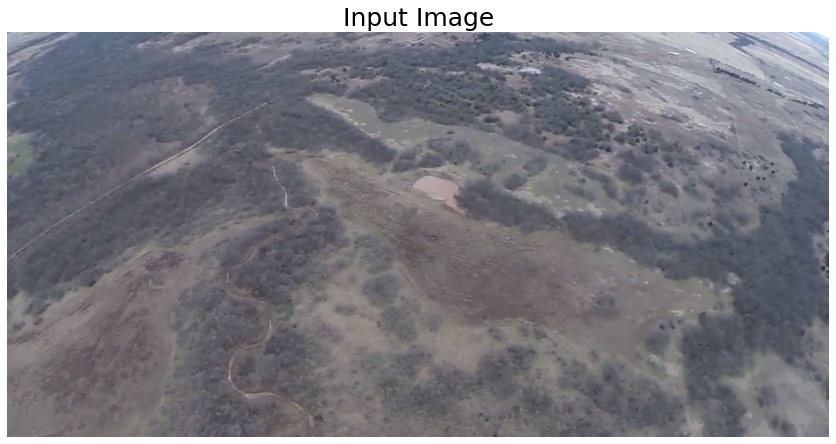

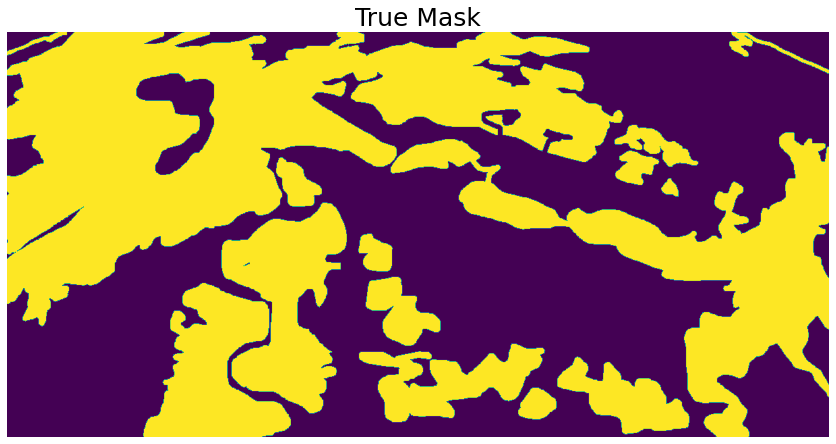

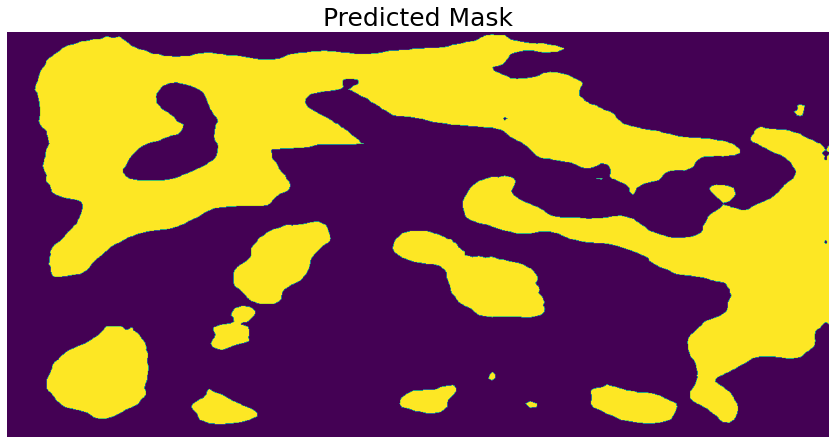

In [ ]:
result = model.predict(new_img, batch_size= 1)
result = np.squeeze(result, 0)

from skimage.transform import resize
resized_img_mask = resize(result, (h,w))

list_images = []
list_images = np.array(list_images).astype(object)
print(list_images.dtype)


titles = ['Input Image', 'True Mask', 'Predicted Mask']

for i in range(3):
  plt.figure(figsize=(h/12, w/12))
  plt.subplot(1, 3, i+1)
  plt.title(titles[i], fontsize = 25)
  if (i==0):
    plt.imshow(save_img)
  elif (i==1):
    plt.imshow(true_mask)
  else:
    plt.imshow(tf.argmax(resized_img_mask, -1))
  plt.axis('off')
  plt.show()




In [ ]:
def display(display_list, figure_size):
  plt.figure(figsize=figure_size)

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()